In [6]:
# 1_General Monthly figure

import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import Series,DataFrame
from datetime import datetime

import_file = 'PUI_monthly.csv'
import_root = 'data/political uncertainty index/'
output_root = 'figure/'

df = pd.read_csv(import_root+import_file,encoding='utf-8')

In [7]:
def normalize(array):
    mean = array.mean()
    std = array.std(ddof=1)
    array -= mean
    array /= std
    return array

In [8]:
x = df['date']
x = [datetime.strftime(datetime.strptime(d, "%Y-%m"),"%b %y") for d in x]
y1 = df['relation_index']
y2 = df['uncertainty_index']

In [9]:
df[df['date'] >= '2016-03'].head()

,date,relation_index,uncertainty_index,keyword_1,keyword_2,keyword_3,keyword_4,keyword_5
123,2016-03,3.194312,768.515868,中国,发展,经济,国家,创新
124,2016-04,7.682490,454.921977,中国,美国,发展,经济,国家
125,2016-05,6.210085,685.371781,中国,发展,美国,国家,经济
126,2016-06,7.177880,1082.038498,中国,发展,合作,经济,国家
127,2016-07,8.812337,407.718677,中国,美国,南海,发展,国家


In [10]:
y2 = normalize(y2)

Text(145, 13, 'Trade War')

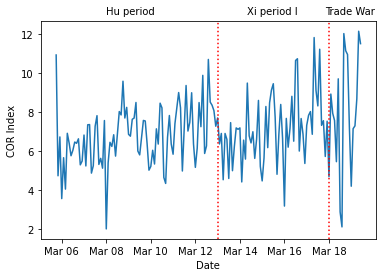

In [11]:
plt.plot(x,y1,'-',label='COR')

# axis label
plt.xlabel('Date')
plt.ylabel('COR Index')

# axis scale
plt.xticks(range(3,164)[::24])

# Add Hu period
date1 = 'Mar 13'
plt.axvline(x=date1,c='red',ls=':')
# plt.axhline(y=10)
plt.annotate('Hu period'.format('Times New Roman'), xy=(0, 10), xytext=(27, 13))

# Add Xi first period
date2 = 'Mar 18'
plt.axvline(x=date2,c='red',ls=':')
# plt.axhline(y=10)
plt.annotate('Xi period I'.format('Times New Roman'), xy=(0, 10), xytext=(103, 13))

# Add Trade War period
# plt.axhline(y=10)
plt.annotate('Trade War'.format('Times New Roman'), xy=(0, 10), xytext=(145, 13))

# Save
# plt.savefig(output_root + 'COR_1.pdf')

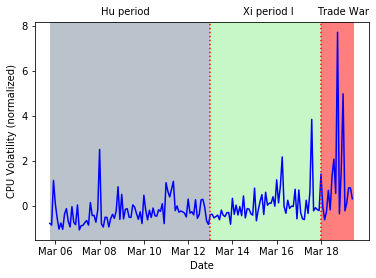

In [8]:
plt.plot(x,y2,'b-',label='CPU')

# axis label
plt.xlabel('Date')
plt.ylabel('CPU Volatility (normalized)')

# axis scale
plt.xticks(range(3,164)[::24])

# Add Hu period
date1 = 'Mar 13'
plt.axvline(x=date1,c='red',ls=':')
# plt.axhline(y=10)
plt.axvspan(0, x.index(date1), facecolor='lightslategrey', alpha=0.5)
plt.annotate('Hu period'.format('Times New Roman'), xy=(0, 0), xytext=(28, 8.5))

# Add Xi first period
date2 = 'Mar 18'
plt.axvline(x=date2,c='red',ls=':')
# plt.axhline(y=10)
plt.axvspan(x.index(date1), x.index(date2), facecolor='lightgreen', alpha=0.5)
plt.annotate('Xi period I'.format('Times New Roman'), xy=(0, 0), xytext=(105, 8.5))

# Add Trade War period
# plt.axhline(y=10)
plt.axvspan(x.index(date2),len(x), facecolor='red', alpha=0.5)
plt.annotate('Trade War'.format('Times New Roman'), xy=(0, 0), xytext=(145, 8.5))

# Save
plt.savefig(output_root + 'CPU_1.pdf')

In [13]:
# 3_compared wtih EPU and VIX
import pandas as pd
import numpy as np
import csv
from datetime import datetime

dv_dir = 'data/EPU and VIX/CBOE.csv'
idv_dir = 'data/political uncertainty index/PUI_monthly.csv'
epu_dir = 'data/EPU and VIX/GEPU.csv'
epu2_dir = 'data/EPU and VIX/RM_EPU.csv'

dv = pd.read_csv(dv_dir)
idv = pd.read_csv(idv_dir, encoding='utf-8')
epu = pd.read_csv(epu_dir)
epu2 = pd.read_csv(epu2_dir)

In [14]:
# cut the time series to fit all data files
from datetime import datetime

idv = idv[(idv['date'] >= dv['date'].loc[0]) & (idv['date'] <= epu['date'].loc[len(epu)-1])]
dv = dv[(dv['date'] >= epu['date'].loc[0]) & (dv['date'] <= epu['date'].loc[len(epu)-1])]
epu = epu[(epu['date'] >= idv['date'].loc[0]) & (epu['date'] <= idv['date'].loc[len(idv)-1])]
epu2 = epu2[(epu2['date'] >= idv['date'].loc[0]) & (epu2['date'] <= idv['date'].loc[len(idv)-1])]

In [15]:
idv['date'] = pd.to_datetime(idv['date'])
dv['date'] = pd.to_datetime(dv['date'])
epu['date'] = pd.to_datetime(epu['date'])
epu2['date'] = pd.to_datetime(epu2['date'])

idv.set_index("date", inplace=True)
dv.set_index("date", inplace=True)
epu.set_index("date", inplace=True)
epu2.set_index("date", inplace=True)

In [16]:
# Variable sets

# add a constant
idv['const'] = 1
epu['const'] = 1
epu2['const'] = 1

dv['vix'] = np.log(dv['vix'])
idv['uncertainty_index'] = np.log(idv['uncertainty_index'])
idv['relation_index'] = np.log(idv['relation_index'])

idv['uncertainty_index-1'] = idv.shift(1)['uncertainty_index']
idv['relation_index-1'] = idv.shift(1)['relation_index']

reg1 =['uncertainty_index']
reg2 = ['GEPU_current']
reg3 = ['GEPU_ppp']
reg4 = ['CEPU']
reg5 = ['EPU']

In [17]:
from statsmodels.iolib.summary2 import summary_col
import statsmodels.api as sm
from sklearn import linear_model
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.datasets import make_regression


regs1 = [reg1]
regs2 = [reg2,reg3]
regs3 = [reg4,reg5]
reg_names = ['(1)','(2)','(3)','(4)','(5)']
info_dict = {'R-squared': lambda x: f"{x.rsquared:.2f}",
             'No. observations': lambda x: f"{int(x.nobs):d}"}
regressor_order = ['relation_index',
                   'uncertainty_index',
                   'GEPU_current',
                   'GEPU_ppp',
                   'CEPU',
                   'const'
                  ]
ols_results = []
results = []

for reg in regs1:   
    result = sm.OLS(dv['vix'], idv[reg], missing='drop').fit()
    ols_results.append(result)
for reg in regs2:
    result = sm.OLS(dv['vix'], epu[reg], missing='drop').fit()
    ols_results.append(result)
for reg in regs3:
    result = sm.OLS(dv['vix'], epu2[reg], missing='drop').fit()
    ols_results.append(result)

print("OLS")
results_table = summary_col(results=ols_results,
                            float_format='%0.3f',
                            stars=True,
                            model_names=reg_names,
                            info_dict=info_dict,
                            regressor_order=regressor_order)
results_table.add_title('Table 1 - News Credibility: OLS')
# print(results_table)
print(results_table.as_latex())

OLS
\begin{table}
\caption{Table 1 - News Credibility: OLS}
\label{}
\begin{center}
\begin{tabular}{llllll}
\hline
                   & (1)      & (2)      & (3)      & (4)      & (5)       \\
\hline
uncertainty\_index & 0.486*** &          &          &          &           \\
                   & (0.006)  &          &          &          &           \\
GEPU\_current      &          & 0.019*** &          &          &           \\
                   &          & (0.001)  &          &          &           \\
GEPU\_ppp          &          &          & 0.018*** &          &           \\
                   &          &          & (0.001)  &          &           \\
CEPU               &          &          &          & 0.016*** &           \\
                   &          &          &          & (0.001)  &           \\
EPU                &          &          &          &          & 0.008***  \\
                   &          &          &          &          & (0.001)   \\
R-squared          &